In [ ]:
pip install -q opencv-python

In [ ]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):

  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(),
                            reset_crop_region=False)

  return person

Cloning into 'examples'...
remote: Enumerating objects: 23729, done.
remote: Counting objects: 100% (693/693), done.
remote: Compressing objects: 100% (430/430), done.
remote: Total 23729 (delta 227), reused 618 (delta 175), pack-reused 23036
Receiving objects: 100% (23729/23729), 44.18 MiB | 15.74 MiB/s, done.
Resolving deltas: 100% (12875/12875), done.
Updating files: 100% (2850/2850), done.


In [ ]:
csvs_out_test_path = 'test_data (3).csv'
csvs_out_train_path = 'train_data (4).csv'

In [ ]:
def load_pose_landmarks(csv_path):
  "Loads a CSV created by MoveNetPreprocessor."

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [ ]:

X, y, class_names, _ = load_pose_landmarks(csvs_out_test_path)


X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [ ]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_train_path)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 54 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   file_name             862 non-null    object 
 1   NOSE_x                862 non-null    float64
 2   NOSE_y                862 non-null    float64
 3   NOSE_score            862 non-null    float64
 4   LEFT_EYE_x            862 non-null    float64
 5   LEFT_EYE_y            862 non-null    float64
 6   LEFT_EYE_score        862 non-null    float64
 7   RIGHT_EYE_x           862 non-null    float64
 8   RIGHT_EYE_y           862 non-null    float64
 9   RIGHT_EYE_score       862 non-null    float64
 10  LEFT_EAR_x            862 non-null    float64
 11  LEFT_EAR_y            862 non-null    float64
 12  LEFT_EAR_score        862 non-null    float64
 13  RIGHT_EAR_x           862 non-null    float64
 14  RIGHT_EAR_y           862 non-null    float64
 15  RIGHT_EAR_score       8

In [ ]:
def calculate_center(landmarks, left_part, right_part):
    left = tf.gather(landmarks, left_part.value, axis=1)
    right = tf.gather(landmarks, right_part.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center

def calculate_pose_size(landmarks, torso_multiplier=2.5):

    hips_center = calculate_center(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)

    shoulders_center = calculate_center(landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER)

    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    pose_center = calculate_center(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    pose_center = tf.broadcast_to(pose_center, [tf.size(landmarks) // (17 * 2), 17, 2])

    dist_to_pose_center = tf.gather(landmarks - pose_center, 0, axis=0, name="dist_to_pose_center")
    max_dist = tf.reduce_max(tf.linalg.norm(dist_to_pose_center, axis=0))
    pose_size = tf.maximum(torso_size * torso_multiplier, max_dist)

    return pose_size

In [ ]:
def normalize_landmarks(landmarks):
    """Normalizes pose landmarks by centering them at (0,0) and scaling to a constant pose size."""
    pose_center = calculate_center(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    pose_center = tf.broadcast_to(pose_center, [tf.size(landmarks) // (17 * 2), 17, 2])
    landmarks = landmarks - pose_center
    pose_size = calculate_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks

In [ ]:
def landmarks_to_embedding(landmarks_and_scores):
    """Converts pose landmarks into a flattened pose embedding."""
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    normalized_landmarks = normalize_landmarks(reshaped_inputs[:, :, :2])

    embedding = keras.layers.Flatten()(normalized_landmarks)

    return embedding

In [ ]:
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape_2 (Reshape)         (None, 17, 3)                0         ['input_3[0][0]']             
                                                                                                  
 tf.__operators__.getitem_2  (None, 17, 2)                0         ['reshape_2[0][0]']           
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.compat.v1.gather_18 (TF  (None, 2)                    0         ['tf.__operators__.getit

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)


In [ ]:
# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
31/33 [===========================>..] - ETA: 0s - loss: 1.7102 - accuracy: 0.3347
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to weights.best.hdf5
33/33 [==============================] - 2s 20ms/step - loss: 1.7038 - accuracy: 0.3441 - val_loss: 1.5915 - val_accuracy: 0.6667
Epoch 2/200
30/33 [==========================>...] - ETA: 0s - loss: 1.4944 - accuracy: 0.5875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.66667 to 0.73118, saving model to weights.best.hdf5
33/33 [==============================] - 0s 7ms/step - loss: 1.4857 - accuracy: 0.5913 - val_loss: 1.2743 - val_accuracy: 0.7312
Epoch 3/200
31/33 [===========================>..] - ETA: 0s - loss: 1.1758 - accuracy: 0.6754
Epoch 3: val_accuracy did not improve from 0.73118
33/33 [==============================] - 0s 6ms/step - loss: 1.1658 - accuracy: 0.6730 - val_loss: 0.9194 - val_accuracy: 0.7204
Epoch 4/200
33/33 [==============================] - ETA: 0s - loss: 0.8757 - accuracy: 0.7357
Epoch 4: val_accuracy improved from 0.73118 to 0.79570, saving model to weights.best.hdf5
33/33 [==============================] - 0s 7ms/step - loss: 0.8757 - accuracy: 0.7357 - val_loss: 0.6649 - val_accuracy: 0.7957
Epoch 5/200
18/33 [===============>..............] - ETA: 0s - loss: 0.7272 - accuracy: 0.7743
Epoch 5: val_accuracy improved from 0.79570 to 0.83871, saving model to weights.best.hdf5
33/33 

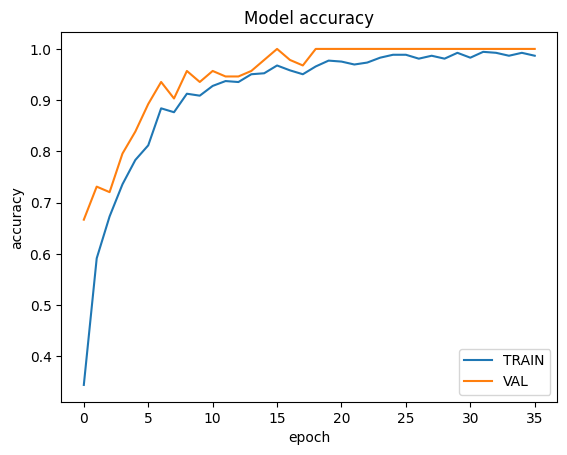

In [ ]:
# Visualize the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

Epoch 1/36 - Training Accuracy: 0.3441 - Validation Accuracy: 0.6667
Epoch 2/36 - Training Accuracy: 0.5913 - Validation Accuracy: 0.7312
Epoch 3/36 - Training Accuracy: 0.6730 - Validation Accuracy: 0.7204
Epoch 4/36 - Training Accuracy: 0.7357 - Validation Accuracy: 0.7957
Epoch 5/36 - Training Accuracy: 0.7833 - Validation Accuracy: 0.8387
Epoch 6/36 - Training Accuracy: 0.8118 - Validation Accuracy: 0.8925
Epoch 7/36 - Training Accuracy: 0.8840 - Validation Accuracy: 0.9355
Epoch 8/36 - Training Accuracy: 0.8764 - Validation Accuracy: 0.9032
Epoch 9/36 - Training Accuracy: 0.9125 - Validation Accuracy: 0.9570
Epoch 10/36 - Training Accuracy: 0.9087 - Validation Accuracy: 0.9355
Epoch 11/36 - Training Accuracy: 0.9278 - Validation Accuracy: 0.9570
Epoch 12/36 - Training Accuracy: 0.9373 - Validation Accuracy: 0.9462
Epoch 13/36 - Training Accuracy: 0.9354 - Validation Accuracy: 0.9462
Epoch 14/36 - Training Accuracy: 0.9506 - Validation Accuracy: 0.9570
Epoch 15/36 - Training Accura

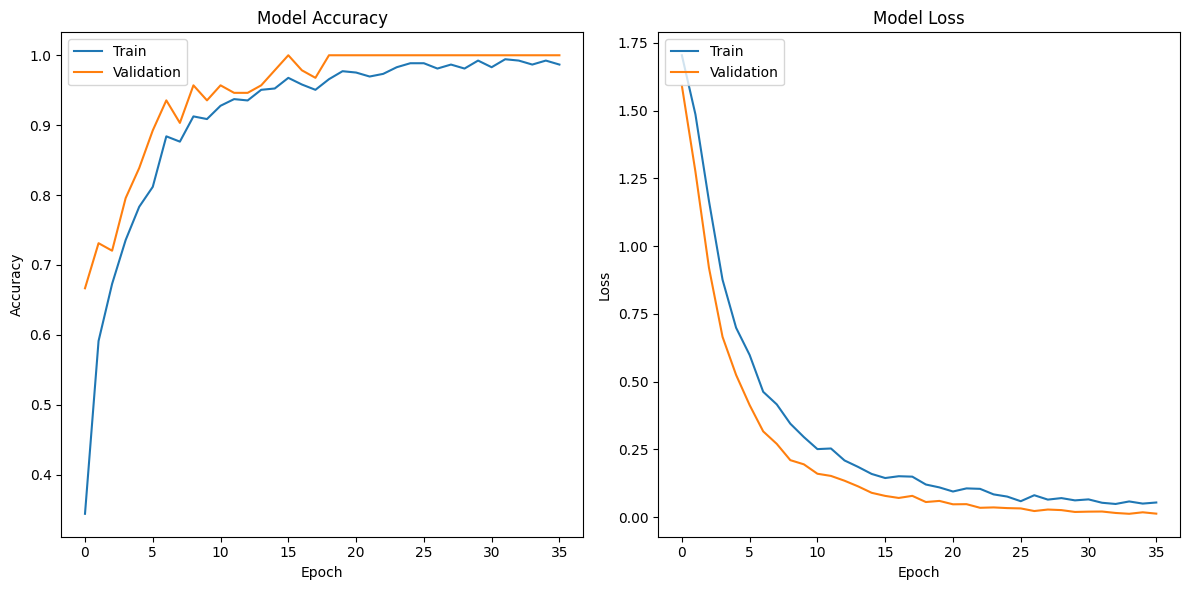

In [ ]:
# Display training and validation accuracy values
for epoch in range(len(history.history['accuracy'])):
    train_acc = history.history['accuracy'][epoch]
    val_acc = history.history['val_accuracy'][epoch]
    print(f'Epoch {epoch + 1}/{len(history.history["accuracy"])} - Training Accuracy: {train_acc:.4f} - Validation Accuracy: {val_acc:.4f}')

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

27/27 [==============================] - 0s 2ms/step - loss: 0.9273 - accuracy: 0.7889


27/27 [==============================] - 0s 2ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

       chair       0.87      0.72      0.79       167
       cobra       0.81      0.61      0.70       113
         dog       0.96      0.85      0.90       139
       plank       0.65      0.92      0.76       182
        tree       0.80      0.90      0.85       184
     warrior       0.76      0.51      0.61        77

    accuracy                           0.79       862
   macro avg       0.81      0.75      0.77       862
weighted avg       0.81      0.79      0.79       862



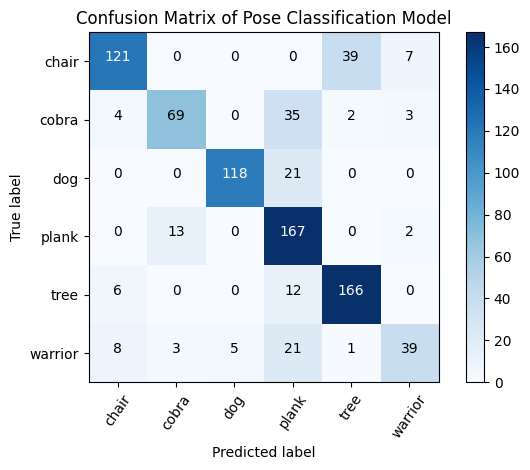

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)


y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]


cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')


print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [ ]:
model.save('your_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

Model size: 27KB


In [ ]:
with open('pose_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [ ]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.7923433874709976
